## **Surface Crack Detection using  Quantum-classical Neural Networks enabled by QKA with PyTorch and Qiskit**



CNN is a type of neural network which uses a special operation called convolution and works best on image dataset.<br>

There are a lot of preprocessing methods that can be used in this pipeline.

Convolution is a multiplication operation between an input and a filter. It's not a simple multiplication process, rather, it is computed by multiplying the input with the filter over a delayed period of time.

**Input * filter -> Answer**

As more and more ideas based on Hybrid Learning Environment come up with combining classical and quantum world to solve various problems. <br>Here is one approach that uses a machine learning framework, PyTorch to create a Hybrid Learning Environment.<br> With this Hybrid approach, a system can be created  with classical neural network, but with some of the nodes replaced with quantum circuit. 

**Quantum Kernel Alignment (QKA):** Quantum computers allow to evaluate kernels to be used e.g. in Support Vector Machines (SVM), Quantum Neural Network (QNN)  on exponentially large feature spaces. This may help to improve the performance of machine learning models and lead to higher accuracies. QKA extends this idea to parametrized kernels that are trained to best match the data.


**Implementation:**

>Step 0 : Installing & Importing Required Python Modules <br>Step 1 : Load the image dataset.<br> Step 2 : Preprocessing the image dataset.<br>Step 3: Calculating the Kernel Matrix so can be used as weights for a custom convolutional layer  <br> Step 4 : Defining the model architecture and  adding a custom layer for training our model.<br> Step 5 : Train our model for 20 epochs.<br> Step 6 : Using the trained model to make inference of test dataset.<br> Step 7 : Visualizing the results of data

##**Installing Required Modules**

In [ ]:
!pip install qiskit 
!pip install qiskit-aer-gpu
!pip install qiskit_machine_learning
!pip install torch
!pip install torchvision
!pip install kaggle

##**Importing Modules**

In [ ]:
# If local dataset is not available
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"meghashritadas","key":"3ed94e1ca30610a95baf6af94e621133"}'}

In [ ]:
! mkdir ~/.kaggle                           # Make directory named kaggle
! cp kaggle.json ~/.kaggle/                 # Copy kaggle.json file there
! chmod 600 ~/.kaggle/kaggle.json           # Change the permissions of the file.

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Importing Required Python Modules
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#Importing Pytorch Specific Modules
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, transforms,models
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
from sklearn.model_selection import KFold

#Importing Qiskit Specific Modules
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap

# # Qiskit Machine Learning
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.kernels import QuantumKernel
## If local dataset is not available then uncomment below line
import kaggle

#**Checking for GPU Availability**

In [ ]:
simulator = qiskit.Aer.get_backend('aer_simulator')

use_cuda = torch.cuda.is_available()

print('CUDA available:', use_cuda)

if use_cuda:
    device = torch.device('cuda')
    print('Training on GPU...')
    simulator.set_options(device='GPU')
else:
    device = torch.device('cpu')
    print('Training on CPU...')

CUDA available: True
Training on GPU...


## **Step 1: Load the Dataset and Visualize it**
* Link to the cracks data set:  https://www.kaggle.com/arunrk7/surface-crack-detection/metadata


In [ ]:
!kaggle datasets download -d arunrk7/surface-crack-detection     # Downloading the zip file using Kaggle Credentials

surface-crack-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip surface-crack-detection.zip                            # Unzip the data
from IPython.display import clear_output
#clear_output()

Archive:  surface-crack-detection.zip
replace Negative/00001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
crack_images = os.listdir('Positive/')
print("Number of Crack Images: ", len(crack_images))

Number of Crack Images:  20000


In [ ]:
no_crack_images = os.listdir('Negative/')
print("Number of No Crack Images: ", len(no_crack_images))

Number of No Crack Images:  20000


Visualize Random images with cracks

*****************Random Images with Cracks**************************


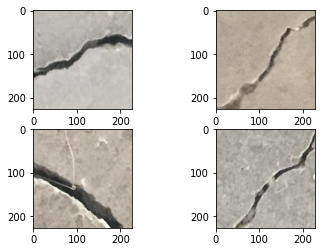

In [ ]:
random_indices = np.random.randint(0, len(crack_images), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[3])))

Visualize Random images with no cracks

*****************Random Images without Cracks**************************


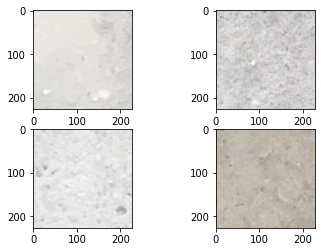

In [ ]:
random_indices = np.random.randint(0, len(no_crack_images), size=4)
print("*****************Random Images without Cracks**************************")
random_images = np.array(no_crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[3])))

## **Create Train and Val Data sets**

### Create training folder

In [ ]:
!rm -rf train
base_dir = cwd
files = os.listdir(base_dir)

In [ ]:
##Considering only 1000 images from each class in order to restrict Compute resource utilization
def create_training_data(folder_name):
    files_list = os.listdir(os.path.join(base_dir,folder_name))
    files_list = files_list[0:1000]
    train_dir = f"{base_dir}/train/{folder_name}"
    os.makedirs(train_dir)
    for f in files:
          search_object = re.search(folder_name, f)
          if search_object:
            for file_name in files_list:
              shutil.copy(f'{base_dir}/{folder_name}/{file_name}', train_dir)

In [ ]:
create_training_data('Positive')
create_training_data('Negative')
!rm -rf val

### Move images randomly from training to val folders

In [ ]:
os.makedirs('val/Positive')
os.makedirs('val/Negative')

In [ ]:
positive_train = base_dir + "/train/Positive/"
positive_val = base_dir + "/val/Positive/"
negative_train = base_dir + "/train/Negative/"
negative_val = base_dir + "/val/Negative/"

positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)

In [ ]:
print(len(positive_files), len(negative_files))             # Checking for the total count of file to be unchanged. Expected output: 20000 20000

1000 1000


In [ ]:
for f in positive_files:
    if random.random() > 0.80:
        shutil.move(f'{positive_train}/{f}', positive_val)   # moving files to positivr_val

In [ ]:
for f in negative_files:
    if random.random() > 0.80:
        shutil.move(f'{negative_train}/{f}', negative_val)   # moving files to negative_val

## **Step 2: Preprocessing the Image Dataset**
## Pytorch data loader and Transforms

### Compute mean and std deviation for the dataset

There are 3 channels in a RGB IMAGE.
> 1. Red
2. Green
3. Blue

In [ ]:
mean_nums = [0.5, 0.5, 0.5]
std_nums = [0.5, 0.5, 0.5]

### Define Data Augmentation and Transforms

In [ ]:
import torchvision.transforms

In [ ]:
data_path_train = os.path.join(cwd, 'train')
data_path_test = os.path.join(cwd, 'val')
chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

### Create the Data Loader

In [ ]:
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=2,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [ ]:
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  1597
Class Names are:  ['Negative', 'Positive']
torch.Size([8, 3, 224, 224]) torch.Size([8])


In [ ]:
test_loader, test_size, class_names = load_dataset('val', 8)
print("Test Data Set size is: ", test_size)
print("Class Names are: ", class_names)
inputs_test, classes_test = next(iter(test_loader))
print(inputs_test.shape, classes_test.shape)

Test Data Set size is:  403
Class Names are:  ['Negative', 'Positive']
torch.Size([8, 3, 224, 224]) torch.Size([8])


### Visualize the Augmented Data Set

##Define Quantum Circuit and Layer

Let's test the implementation

In [ ]:
# Additional torch-related imports
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [ ]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

In [ ]:
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

In [ ]:
# Define QNN
feature_map = ZZFeatureMap(10)
ansatz = RealAmplitudes(10, reps=1)
# REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
qnn4 = TwoLayerQNN(
    10, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
)
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZZZZZZZZZ),
  CircuitStateFn(
       ┌──────────────────────────────────────────────────────────────────┐»
  q_0: ┤0                                                                 ├»
       │                                                                  │»
  q_1: ┤1                                                                 ├»
       │                                                                  │»
  q_2: ┤2                                                                 ├»
       │                                                                  │»
  q_3: ┤3                                                                 ├»
       │                                                                  │»
  q_4: ┤4                                                                 ├»
       │  ZZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9]) │»
  q_5: ┤5                                                                 ├»
    

In [ ]:
simulator = qiskit.Aer.get_backend('aer_simulator')

use_cuda = torch.cuda.is_available()

print('CUDA available:', use_cuda)

if use_cuda:
    device = torch.device('cuda')
    print('Training on GPU...')
    simulator.set_options(device='GPU')
else:
    device = torch.device('cpu')
    print('Training on CPU...')

CUDA available: True
Training on GPU...


### Creating a "Quantum-Classical Class" with PyTorch <a id='qc-class'></a>


In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) #####

        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 25088)
        self.fc3 = nn.Linear(25088, 10)
        self.qnn = TorchConnector(qnn4)
        

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = self.qnn(x)
        x = torch.chunk(x,10, dim=1)
        #x = tuple([hy(x_) for hy, x_ in zip(self.hybrid, x)])
        return cat((x, 1 - x), -1)

In [ ]:
# import torchvision.models as models
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_ft = models.vgg16(pretrained=True)

# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)
# #model_ft = model_ft.to(device)
# criterion = nn.CrossEntropyLoss()
# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda

model = VGG16() #to compile the model
model = model.to(device)
from torchsummary import summary
print(summary(model, (3, 224, 224)))

TypeError: ignored

# **Step 5: Training our Model**
